In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [3]:
# Save the input and target variables

print(diabetes_dataset.keys())
data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
# Normalise the target data (this will make clearer training curves)
print(targets[:10])
targets = (targets - targets.mean(axis=0)) / targets.std()
# Z normalization ? 

print(targets[:10])

[151.  75. 141. 206. 135.  97. 138.  63. 110. 310.]
[-0.01471948 -1.00165882 -0.14457991  0.69951294 -0.22249618 -0.71596585
 -0.18353805 -1.15749134 -0.54714728  2.05006151]


In [5]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1) # 10% of train data is test data

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    return model

model = get_model()

In [7]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

In [9]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [10]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 1.4906 - mae: 0.9115


[1.3593731615278455, 0.9115301]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

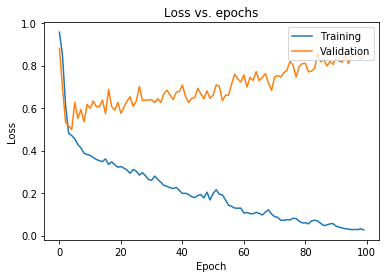

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Vastly overfits training data

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],), kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [16]:
# Compile the model

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

In [17]:
# Train the model, with some of the data reserved for validation

hostory = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=1)

Train on 337 samples, validate on 60 samples
Epoch 1/100
337/337 [==============================] - 2s 7ms/sample - loss: 0.9784 - mae: 0.8451 - val_loss: 0.9473 - val_mae: 0.8366
Epoch 2/100
337/337 [==============================] - 0s 557us/sample - loss: 0.9723 - mae: 0.8438 - val_loss: 0.9233 - val_mae: 0.8282
Epoch 3/100
337/337 [==============================] - 0s 605us/sample - loss: 0.9448 - mae: 0.8326 - val_loss: 0.8577 - val_mae: 0.7979
Epoch 4/100
337/337 [==============================] - 0s 598us/sample - loss: 0.8686 - mae: 0.7942 - val_loss: 0.7282 - val_mae: 0.7280
Epoch 5/100
337/337 [==============================] - 0s 589us/sample - loss: 0.7001 - mae: 0.7096 - val_loss: 0.5603 - val_mae: 0.6164
Epoch 6/100
337/337 [==============================] - 0s 585us/sample - loss: 0.6399 - mae: 0.6547 - val_loss: 0.6264 - val_mae: 0.6291
Epoch 7/100
337/337 [==============================] - 0s 369us/sample - loss: 0.5431 - mae: 0.5999 - val_loss: 0.5638 - val_mae: 0.618

337/337 [==============================] - 0s 604us/sample - loss: 0.3986 - mae: 0.5024 - val_loss: 0.6056 - val_mae: 0.6288
Epoch 61/100
337/337 [==============================] - 0s 580us/sample - loss: 0.3506 - mae: 0.4735 - val_loss: 0.6071 - val_mae: 0.6354
Epoch 62/100
337/337 [==============================] - 0s 585us/sample - loss: 0.3730 - mae: 0.4794 - val_loss: 0.6309 - val_mae: 0.6410
Epoch 63/100
337/337 [==============================] - 0s 607us/sample - loss: 0.3732 - mae: 0.4803 - val_loss: 0.5609 - val_mae: 0.6180
Epoch 64/100
337/337 [==============================] - 0s 591us/sample - loss: 0.3384 - mae: 0.4577 - val_loss: 0.6162 - val_mae: 0.6105
Epoch 65/100
337/337 [==============================] - 0s 580us/sample - loss: 0.3678 - mae: 0.4816 - val_loss: 0.5433 - val_mae: 0.5893
Epoch 66/100
337/337 [==============================] - 0s 580us/sample - loss: 0.3776 - mae: 0.4983 - val_loss: 0.5595 - val_mae: 0.6043
Epoch 67/100
337/337 [=========================

In [18]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 1.2828 - mae: 0.8276


[1.041040301322937, 0.8276006]

#### Plot the learning curves

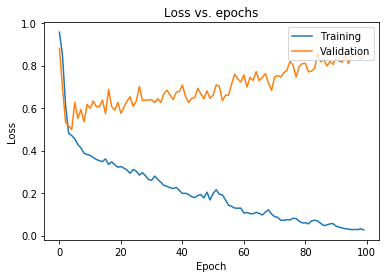

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Overfitting is not completely fixed but there is an improvement from before

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        # Do something once at the start of training.
        print("Starting training...")

    def on_train_batch_begin(self, batch, logs=None):
        # Do something at the start of every batch iteration. The batch number is passed as the batch argument.
        print(f"Training: Starting batch {batch}")

    def on_epoch_begin(self, epoch, logs=None):
        # Do something at the end of every epoch. The epoch number is passed as the epoch argument.
        print(f"Starting epoch {epoch}")
        
    def on_train_end(self, logs=None):
        # Do something once at the start of training.
        print("Finished training.")

    def on_train_batch_end(self, batch, logs=None):
        # Do something at the start of every batch iteration. The batch number is passed as the batch argument.
        print(f"Training: Finished batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        # Do something at the end of every epoch. The epoch number is passed as the epoch argument.
        print(f"Finished epoch {epoch}")
           
class TestingCallback(Callback):
    def on_test_begin(self, logs=None):
        # Do something once at the start of training.
        print("Starting testing...")

    def on_test_batch_begin(self, batch, logs=None):
        # Do something at the start of every batch iteration. The batch number is passed as the batch argument.
        print(f"Testing: Starting batch {batch}")

    def on_epoch_begin(self, epoch, logs=None):
        # Do something at the end of every epoch. The epoch number is passed as the epoch argument.
        print(f"Starting epoch {epoch}")
        
    def on_test_end(self, logs=None):
        # Do something once at the start of training.
        print("Finished testing.")

    def on_test_batch_end(self, batch, logs=None):
        # Do something at the start of every batch iteration. The batch number is passed as the batch argument.
        print(f"Testing: Finished batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        # Do something at the end of every epoch. The epoch number is passed as the epoch argument.
        print(f"Finished epoch {epoch}")
        
class PredictionCallback(Callback):
    def on_predict_begin(self, logs=None):
        # Do something once at the start of training.
        print("Starting prediction...")

    def on_predict_batch_begin(self, batch, logs=None):
        # Do something at the start of every batch iteration. The batch number is passed as the batch argument.
        print(f"Prediction: Starting batch {batch}")

    def on_epoch_begin(self, epoch, logs=None):
        # Do something at the end of every epoch. The epoch number is passed as the epoch argument.
        print(f"Starting epoch {epoch}")
        
    def on_predict_end(self, logs=None):
        # Do something once at the start of training.
        print("Finished prediction.")

    def on_predict_batch_end(self, batch, logs=None):
        # Do something at the start of every batch iteration. The batch number is passed as the batch argument.
        print(f"Prediction: Finished batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        # Do something at the end of every epoch. The epoch number is passed as the epoch argument.
        print(f"Finished epoch {epoch}")

In [21]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)


In [22]:
# Compile the model

model.compile(
    optimizer="adam",
    loss="mse"
)

#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training...
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training.


In [24]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing...
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing.


1.2510231335957844

In [25]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction.


array([[-0.03030959],
       [-0.02799865],
       [-0.03763044],
       [-0.0292721 ],
       [ 0.04840418],
       [-0.02954401],
       [ 0.02638041],
       [ 0.02802172],
       [ 0.02266565],
       [ 0.0009416 ],
       [-0.00250819],
       [-0.04637506],
       [ 0.04162922],
       [ 0.02811241],
       [ 0.00352065],
       [-0.0075093 ],
       [-0.02935537],
       [ 0.00985476],
       [ 0.02934803],
       [ 0.02204369],
       [ 0.00981175],
       [ 0.01939288],
       [ 0.03158706],
       [-0.0461771 ],
       [-0.05104598],
       [-0.00803611],
       [-0.0246179 ],
       [ 0.05130367],
       [ 0.00129329],
       [-0.0272558 ],
       [ 0.01767087],
       [-0.01296078],
       [ 0.03321268],
       [-0.02003663],
       [-0.0383788 ],
       [-0.01029358],
       [-0.01772869],
       [ 0.02025996],
       [-0.04489929],
       [-0.01954331],
       [ 0.02536343],
       [ 0.02167996],
       [-0.03473367],
       [ 0.03031677],
       [-0.00188343]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [39]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer="adam", loss="mse")
unreg_history = unregularized_model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [40]:
# Evaluate the model on the test set

unregularized_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 1.1108


0.9586891995535957

In [41]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-8, 0.2)
regularized_model.compile(optimizer="adam", loss="mse")
reg_history = regularized_model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [42]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 1.1628


1.2510231335957844

#### Plot the learning curves

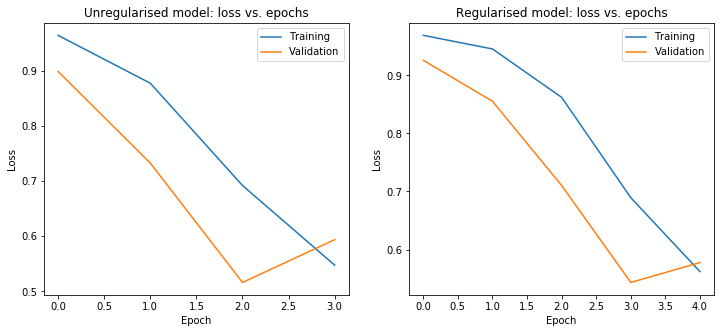

In [33]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

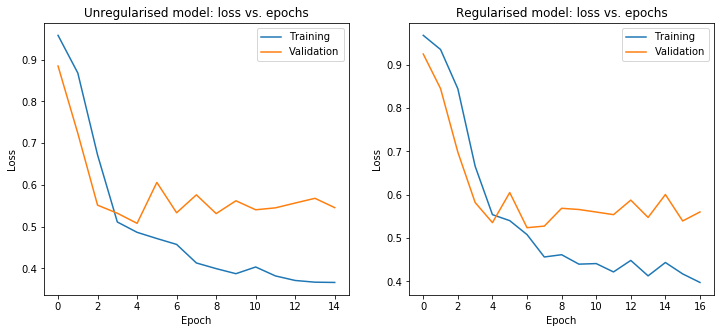

In [38]:
# Plot the training and validation loss - with patience 10

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

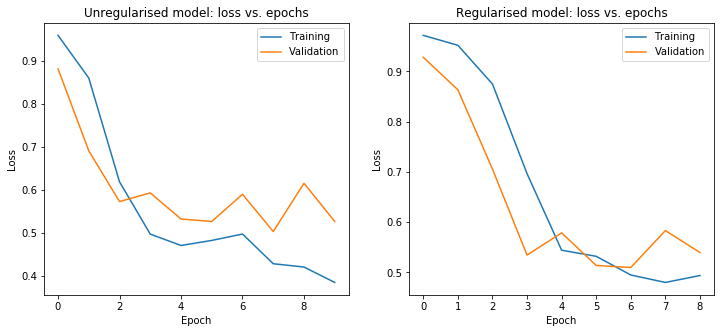

In [43]:
# Plot the training and validation loss - with patience 2

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()